# 1. Overview

In this project, we use a dataset containing around 10 years of daily weather observations from many locations across Australia, which is downloaded from Bureau of Meteorology, Australia. You can access it from Kaggle: <https://www.kaggle.com/jsphyg/weather-dataset-rattle-package>.

Let's define one supervised learning problem and one unsupervised learning problem first:

- Supervised learning: predict whether it will rain on the next day based on the weather observations of a given day (binary classification).

- Unsupervised learning: cluster the observation stations (mainly cities) based on weather records.

We will first explore this dataset by some visualizations, and then train 3 different supervised models and 2 different unsupervised models to deal with the above problems.

# 2. Data exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import pickle

## 2.1 Dataset general descriptions

Firstly, we load the dataset from local device.

In [2]:
df_weather = pd.read_csv('data/weatherAUS.csv')

Let's have a quick glance at this dataset.

In [3]:
df_weather.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
df_weather.shape

(145460, 23)

In [5]:
# date range
np.min(df_weather.Date), np.max(df_weather.Date)

('2007-11-01', '2017-06-25')

In [6]:
# description of "Location" column
df_weather.Location.describe()

count       145460
unique          49
top       Canberra
freq          3436
Name: Location, dtype: object

This dataset contains **145,460** records, and **23** columns. The observation date is recorded in the first column, and the second column represents where the observation station is located. The date range from **December 1, 2008** to **June 25, 2017**. There are **49** different observation stations in this dataset, where the capital -- **Canberra** is the most frequent one.

The corresponding weather conditions are recorded in the 3rd to 21st columns. To notice that some columns contain so many empty values, so we must take measures to deal with this issue when data preprocessing. And the last two columns are boolean variables, which show whether it rains on the given day, and whether it will rain on the next day, respectively.



## 2.2 Visualizations

Let's make some plots to understand this dataset better.

### 2.2.1 Frequency of rain

We would like to know what frequencies of rain are in different observation locations. Let's make a bar plot.

In [7]:
# convert "RainToday" and "RainTomorrow" columns into boolean format
# Rain tomorrow -- 1
# Not rain tomorrow -- 0
df_weather.RainToday = df_weather.RainToday.apply(lambda x: 1 if x == 'Yes' else 0)
df_weather.RainTomorrow = df_weather.RainTomorrow.apply(lambda x: 1 if x == 'Yes' else 0)

In [8]:
# calculate probability of rain for each observation location, and sort by descending values
gb = df_weather[['Location', 'RainToday']].groupby('Location')
P_r = (gb.apply(np.sum)['RainToday'] / gb.apply(len)).sort_values(ascending=False)

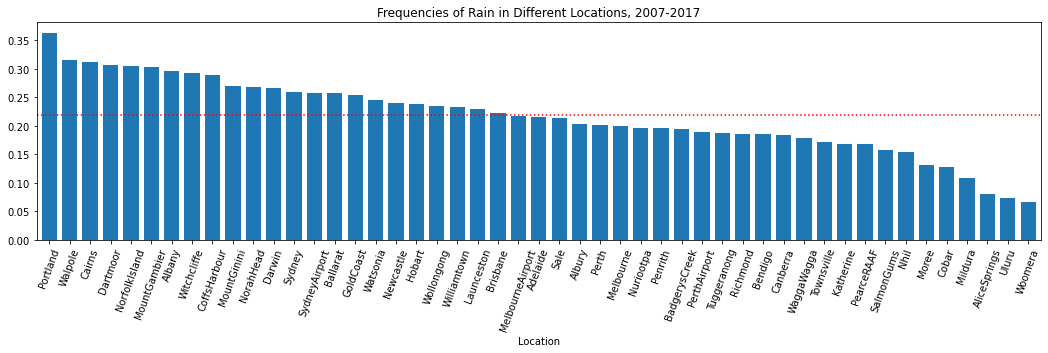

In [9]:
plt.figure(figsize=(18,4))
P_r.plot(kind='bar', rot=70, width = 0.75)
# plot average line
plt.hlines(sum(df_weather.RainToday)/len(df_weather), -1, 49, color = 'r', linestyles = ':')
plt.title('Frequencies of Rain in Different Locations, 2007-2017');

It can be found that the frequency of rain in **Portland** is the highest, while the frequency in **Woomera** is the lowest. The red dotted line represents the frequency of rain for Australia as a whole.

### 2.2.2 Rain vs. Time

The size of rainfall significantly depends on the season. Let's use data from 2014 to 2016, to analyze the effect seasonality.

In [10]:
# split the text of date into year, month, and day
df_weather['Year'] = df_weather.Date.apply(lambda x: int(x[:4]))
df_weather['Month'] = df_weather.Date.apply(lambda x: int(x[5:7]))
df_weather['Day'] = df_weather.Date.apply(lambda x: int(x[8:]))

In [11]:
# calculate monthly rainfall for each location
df_rain_lc = df_weather[['Location', 'Year', 'Month', 'Rainfall']].groupby(['Location', 'Year', 'Month']).apply(sum)['Rainfall'].reset_index()

# calculate average rainfall for each month
df_rain_month = df_rain_lc.groupby(['Year', 'Month']).apply(np.mean)['Rainfall'][49:-6].reset_index()

E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


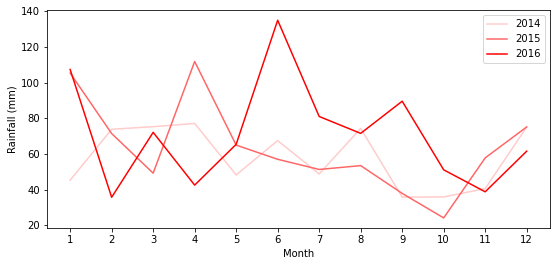

In [12]:
plt.figure(figsize=(9,4))
color_dict = {2016:(1, 0, 0), 2015:(1, 0.4, 0.4), 2014:(1, 0.8, 0.8)}
plot_list = []

for i in (2014, 2015, 2016):
    df_rain_month_i = df_rain_month[df_rain_month.Year == i]
    plot_list.append(plt.plot(df_rain_month_i.Month, df_rain_month_i.Rainfall, c = color_dict[i]))

plt.xticks(range(1, 13))
plt.xlabel('Month')
plt.ylabel('Rainfall (mm)')
plt.legend(('2014', '2015', '2016'));

We first calculate the total rainfall for each of 49 locations in each of 36 months from Jan 2014 to Dec 2016. And then, we take the average of them. We make 3 line plots for Year 2014, 2015 and 2016, respectively. The y-axis represents the rainfall in millimeters. It is difficult to tell a obvious pattern from the plot, except that the rainfall in the first half of the year is slightly higher than the second half. 

### 2.2.3 Correlation plot

In this part, we want to know what are the correlations between the features we might use in machine learning part, and whether it would rain tomorrow or not. Let's use a heatmap here.

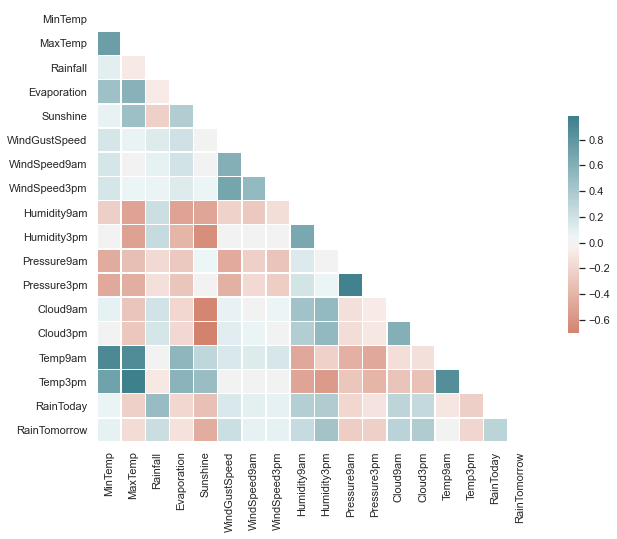

In [13]:
sns.set(style = "white")
cor_matrix = df_weather.iloc[:,:-3].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cor_matrix, dtype = bool))

plt.figure(figsize = (13,8))

# Generate a customized divergingcolormap
cmap = sns.diverging_palette(20, -150, as_cmap = True)

fig4 = sns.heatmap(cor_matrix, mask = mask, cmap = cmap, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5})

It seems that `RainTomorrow` label is relatively highly correlated to the humidity, pressure and cloud condition *especially at 3 pm*, and the sunshine and rainfall as well. It gives us a preliminary understanding of the importance of each feature before stepping into machine learning part. Besides, we can roughly know the correlations between each pair of the features from the plot as well, which may give us some inspirations when we dealing with multicollinearity issues.

# 3. Supervised learning

Let's restate the supervised learning problem again:

> For this task, we predict whether it will rain on the next day based on the weather observations of a given day. So, it is a **binary classification** problem.

## 3.1 Data preprocessing

In [14]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report

### 3.1.1 Feautre engineering

In this part, we are going to do some feature engineering. The main purpose is to make our features more effective before we input them into our models. 

In [15]:
# drop "Evaporation", "Sunshine", "Cloud9am", "Cloud3pm" -- columns with too many NaN values
# drop "RainToday" -- already included in "Rainfall"
# drop "Day", "Date" -- high risk of overfitting
df_weather_dropcl = df_weather.drop(columns = ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'RainToday', 'Day', 'Date'])

In [16]:
# drop records with NaN values
df_weather_dropna = df_weather_dropcl.dropna()

Now, we deal with nominal and numerical data seperately. We use two encoders, one-hot and label encoders, to deal with nominal data.

In [17]:
# use one-hot encoding to encode "Location"
onehot_columns = ['Location']
ohe = OneHotEncoder(sparse=False)
Loc_onehot = ohe.fit_transform(df_weather_dropna[onehot_columns])

In [18]:
# use label encoding to encode following 3 columns
label_columns = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
le = LabelEncoder()
le.fit(df_weather_dropna.WindGustDir.unique())

WindGustDir = le.transform(df_weather_dropna[label_columns[0]])
WindDir9am = le.transform(df_weather_dropna[label_columns[1]])
WindDir3pm = le.transform(df_weather_dropna[label_columns[2]])

In [19]:
# deal with numerical data
df_weather_num = df_weather_dropna.drop(columns = onehot_columns + label_columns)

# create some columns that might be useful
df_weather_num['TempRange'] = df_weather_num.MaxTemp - df_weather_num.MinTemp
df_weather_num['TempChange'] = df_weather_num.Temp3pm - df_weather_num.Temp9am
df_weather_num['PresChange'] = df_weather_num.Pressure3pm - df_weather_num.Pressure9am
df_weather_num['HumidChange'] = df_weather_num.Humidity3pm - df_weather_num.Humidity9am

### 3.1.2 Train and test set preparation

In [20]:
# stack above generated datasets together
X = np.hstack([np.array(df_weather_num.drop(columns = 'RainTomorrow')), Loc_onehot,\
               WindGustDir.reshape(-1,1), WindDir9am.reshape(-1,1), WindDir3pm.reshape(-1,1)])
y = df_weather_num['RainTomorrow']

In [21]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, \
                                                    random_state=1234, stratify=df_weather_dropna.Location)

In [22]:
# standardization
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

### 3.1.3 Metrics

Before we start, let's build two benchmark classifiers. 

1. We predict all samples as `Not rain tomorrow`

2. We use `Rain today` to predict `Rain tomorrow`: if it rains today, then we anticipates it will rain tomorrow, vice versa.

Since it's a binary classification problem, we use two metrics: **accuracy** and **weighted average F1-score**. Let's try above two benchmarks first.

In [23]:
# Benchmark 1
print(classification_report(df_weather_dropna.RainTomorrow, df_weather_dropna.RainTomorrow.apply(lambda x : 0), digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.780     1.000     0.876     88660
           1      0.000     0.000     0.000     25019

    accuracy                          0.780    113679
   macro avg      0.390     0.500     0.438    113679
weighted avg      0.608     0.780     0.683    113679



In [24]:
# Benchmark 2
print(classification_report(df_weather_dropna.RainTomorrow, \
                            df_weather_dropna.Rainfall.apply(lambda x : 1 if x > 0 else 0), digits=3))

              precision    recall  f1-score   support

           0      0.872     0.720     0.789     88660
           1      0.387     0.626     0.478     25019

    accuracy                          0.699    113679
   macro avg      0.629     0.673     0.633    113679
weighted avg      0.765     0.699     0.720    113679



To summarize:

>1. Benchmark 1 -- Accuracy: **0.780**; weighted average F1-score: **0.683**.
>
>2. Benchmark 2 -- Accuracy: **0.699**; weighted average F1-score: **0.720**.

Let's see how much our supervised models can improve these results.

## 3.2 Logistic regression

Logistic regression is a traditional method for binary classification. We use grid search method for all supervised models.

Cross validation is also applied here. We use the default setting -- number of folds equal to 5. For the remaining part of supervised learning, the model selection methods are quite similar.

For logistic regression, we search for the best `C` -- the penalty term of L2 regularization. Our candidates range from **10e-6** to **10e3**.

In [25]:
# grid search
C_list = np.power(10, np.arange(-6, 4) / 1)
parameters = {'C': C_list}

lr = LogisticRegression(penalty='l2')
lr_gs = GridSearchCV(lr, parameters, verbose = 4, n_jobs=20)
lr_gs.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  24 out of  50 | elapsed:   13.4s remaining:   14.6s
[Parallel(n_jobs=20)]: Done  37 out of  50 | elapsed:   18.0s remaining:    6.3s
[Parallel(n_jobs=20)]: Done  50 out of  50 | elapsed:   18.9s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  50 out of  50 | elapsed:   18.9s finished


LogisticRegression(C=10.0)

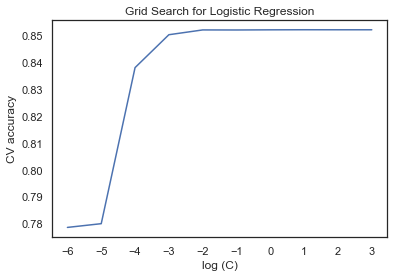

In [26]:
# plot logarithm of C vs. cross validation accuracy
plt.plot(np.arange(-6, 4), lr_gs.cv_results_['mean_test_score'])
plt.xticks(np.arange(-6, 4))
plt.xlabel('log (C)')
plt.ylabel('CV accuracy')
plt.title('Grid Search for Logistic Regression', pad=5)

# What's the best C?
lr_gs.best_estimator_

We can see from the plot that CV accuracy increases as log C increases at the beginning, and then the accuracy doesn't change too much as log C goes positive. By calculation, we find that it returns the highest CV score when log C equals 1 (i.e. C equals 10). Then we use corresponding model for prediction.

In [27]:
print(classification_report(y_test, lr_gs.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      0.881     0.953     0.915      8986
           1      0.742     0.514     0.608      2382

    accuracy                          0.861     11368
   macro avg      0.812     0.733     0.762     11368
weighted avg      0.852     0.861     0.851     11368



The logistic regression model gives us an accuracy of **0.861**, and an F1-score of **0.851**. Both of them are higher than the benchmarks. Let's see how other two models perform first.

## 3.3 Gradient boosting decision tree (GBDT)

GBDT is an ensemble model which aims to reduce bias. Similarly, we use grid search here, to search for the best number of estimators (decision trees). Our candidates range from **100** to **200**.

In [28]:
# The model training was time-consuming, so we save the model locally.

# # Grid search for best "n_estimators"
# parameters = {'n_estimators':list(range(100, 210, 10))}
# gb = GradientBoostingClassifier(random_state=1234)

# gb_gs = GridSearchCV(gb, parameters, verbose = 4, n_jobs=20)
# gb_gs.fit(X_train, y_train);

# # save the model
# pickle.dump(gb_gs, open('saved_models/gbdt_model.sav', 'wb'))

In [29]:
# load the model from disk
gb_gs = pickle.load(open('saved_models/gbdt_model.sav', 'rb'))

GradientBoostingClassifier(n_estimators=200, random_state=1234)

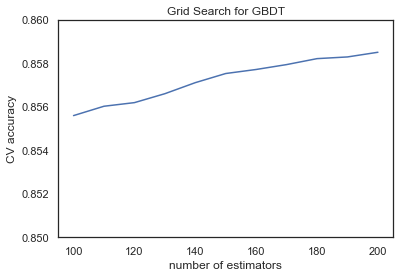

In [30]:
# plot number of estimators vs. cross validation accuracy
plt.plot(np.arange(100, 210, 10), gb_gs.cv_results_['mean_test_score'])
plt.yticks([0.85, 0.852, 0.854, 0.856, 0.858, 0.86])
plt.xlabel('number of estimators')
plt.ylabel('CV accuracy')
plt.title('Grid Search for GBDT', pad=5)

# What's the best number?
gb_gs.best_estimator_

We see from the plot that the CV accuracy **increases strictly** as the number of estimators goes up, though it doesn't change too much (between 0.855 to 0.859). Although the performance might still get better as the number of estimators goes beyond 200, it requires too many computing resources. Hence, we choose the model with the number of estimators equal to 200 as the best one.

In [31]:
print(classification_report(y_test, gb_gs.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      0.885     0.955     0.919      8986
           1      0.759     0.531     0.625      2382

    accuracy                          0.866     11368
   macro avg      0.822     0.743     0.772     11368
weighted avg      0.859     0.866     0.857     11368



The GBDT model gives us an accuracy of **0.866**, and an F1-score of **0.857**, which are slightly higher than the simpler model -- logistic regression model. Let's see another ensemble model next.

## 3.4 Random forest

Random forest is another ensemble model, which belongs to bagging. Different from boosting, it aims to reduce the variance. Similarly, we use grid search here, to search for the best number of estimators (decision trees). Our candidates also range from **100** to **200**.

In [32]:
# The model training was time-consuming, so we save the model locally.

# # Grid search for best "n_estimators"
# parameters = {'n_estimators':list(range(100, 210, 10))}
# rfc = RandomForestClassifier(random_state=1234)

# rf_gs = GridSearchCV(rfc, parameters, verbose = 4, n_jobs=20)
# rf_gs.fit(X_train, y_train);

# # save the model
# pickle.dump(rf_gs, open('saved_models/random_forest_model.sav', 'wb'))

In [33]:
# load the model from disk
rf_gs = pickle.load(open('saved_models/random_forest_model.sav', 'rb'))

RandomForestClassifier(n_estimators=160, random_state=1234)

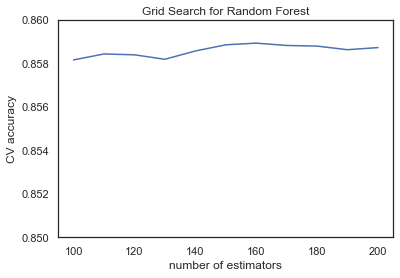

In [34]:
# plot number of estimators vs. cross validation accuracy
plt.plot(np.arange(100, 210, 10), rf_gs.cv_results_['mean_test_score'])
plt.yticks([0.85, 0.852, 0.854, 0.856, 0.858, 0.86])
plt.xlabel('number of estimators')
plt.ylabel('CV accuracy')
plt.title('Grid Search for Random Forest', pad=5)

# What's the best number?
rf_gs.best_estimator_

The plot does not show a clear trend of CV accuracy against the number of estimators. The accuracy seems to **vibrate randomly** between 0.857 to 0.859 as the number of estimators increases, though it seems that the best hyperparameter might lie between 100 to 200. We use the model with the number of estimators equal to 160, which gives the highest CV score, for testing.  

In [35]:
print(classification_report(y_test, rf_gs.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      0.882     0.961     0.920      8986
           1      0.778     0.513     0.618      2382

    accuracy                          0.867     11368
   macro avg      0.830     0.737     0.769     11368
weighted avg      0.860     0.867     0.856     11368



The randon forest model gives us an accuracy of **0.867**, and an F1-score of **0.856**, which are nearly the same as GBDT model. 

## 3.5 Summary and further analysis

Let's summarize the performances of the above 3 supervised learning models.

| Model name | Test accuracy | Test F1-score | Average CV time (s) |
| :---------- | ------------- | ------------- | ------- |
| Benchmark 1 | 0.780 | 0.683 | / | / |
| Benchmark 2 | 0.699 | 0.720 | / | / |
| Logistic regression | 0.861 | 0.851 | **1** |
| GBDT | 0.866 | **0.857** | 129 |
| Random forest | **0.867** | 0.856 | 63 |

* Notes: Average CV time means the average time needed to run a 5-fold cross validation for one hyperparameter setting.

>In conclusion, the three models show similar results. Hence, considering running time, **logistic regression** is good enough to explain this dataset.

Let's look into the weights in the logistic regression model, and see how this model make decisions.

In [36]:
# train logistic regression model with C equal to 10
lr_c10 = LogisticRegression(penalty='l2', C=10)
lr_c10.fit(X_train, y_train);

In [37]:
# get feature names with top-5 highest absolute weights
ranked_list = np.abs(lr_c10.coef_).argsort()[0][::-1]
top5_weights = lr_c10.coef_[0][ranked_list[:5]]
top5_features = df_weather_num.drop(columns = 'RainTomorrow').columns[ranked_list[:5]]
pair_lst = [(top5_features[i], top5_weights[i]) for i in range(5)]

for i in range(5):
    print(f'{pair_lst[i][0]}: {pair_lst[i][1]:.3f}')

Humidity3pm: 0.909
WindGustSpeed: 0.898
Humidity9am: 0.658
HumidChange: 0.406
PresChange: -0.406


The logistic regression model learns that the rainfall next day might be highly positively related to:
- Humidity today (9 am and 3 pm);
- The degree of humidity change during the day (i.e. the more humidity incresed during today, the higher possibility of rain tomorrow);
- Wind speed.

And it might be highly negatively related to:
- The degree of pressure change during the day (i.e. the more pressure decresed during today, the higher possibility of rain tomorrow).

These results make sense from the meteorological perspective, which explains the effectiveness of the logistic model. 

# 4. Unsupervised learning

As shown in public resources, Australia can be roughly divided into **6 states** and **2 territories**. The table below shows the 49 observation stations and their corresponding state or territory:

| State/Territory | Postal | Cities/Regions | Counts |
| :---- | :---- | :---- | ----: |
| New South Wales | NSW | Albury, Badgerys Creek, Cobar, Coffs Harbour,	Moree, Newcastle, Norah Head, Norfolk Island, Penrith, Richmond, Sydney, Sydney Airport, Wagga Wagga, Williamtown, Wollongong | 15 |
| Victoria | VIC | Ballarat, Bendigo, Sale, Melbourne Airport, Melbourne, Mildura, Nhil, Portland, Watsonia, Dartmoor | 10 |
| Western Australia | WA | Albany, Witchcliffe, Pearce RAAF, Perth Airport, Perth, Salmon Gums, Walpole | 7 |
| Queensland | QLD | Brisbane, Cairns, Gold Coast, Townsville | 4 |
| Southern Australia | SA | Adelaide, Mount Gambier, Nuriootpa, Woomera | 4 |
| Northern Territory | NT | AliceSprings, Darwin, Katherine, Uluru | 4 |
| * Australian Capital Territory | ACT | Canberra, Tuggeranong, Mount Ginini| 3 |
| Tasmania | TAS | Hobart, Launceston| 2 |
| **Total Counts** | | | **49** |

*Notes: Australian Capital Territory is geometrically inside New South Wales, it's easy to believe that the weather might be similar in these two areas. So we might treat them as the same division.*

Theoretically, the stations in the same state or territory might have similar weather records. Hence, we want to know if we  cluster those observation stations based on their weather records, can we get a result similar to the divisions above? Then the unsupervised learning problem can be defined as:

> **Cluster** the 49 stations based on their observations.

We will use 2 metrics to determine the best number of clusters:

1. **Adjusted Rand score**, if we assume that the division above is the true label that we want to compare;

2. **Silhouette score**, if we assume that we do not know the true label.

In [38]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score

## 4.1 Data preprocessing

Again, we need to deal with features first. At this time, we keep less number of features (all numerical features) that might be useful for this clustering problem.

In [39]:
df_weather_clust = df_weather.copy()

# create features that would be used in clustering
df_weather_clust['TempRange'] = df_weather_clust.MaxTemp - df_weather_clust.MinTemp
df_weather_clust['TempChange'] = df_weather_clust.Temp3pm - df_weather_clust.Temp9am
df_weather_clust['WindSpeedChange'] = df_weather_clust.WindSpeed3pm - df_weather_clust.WindSpeed9am
df_weather_clust['HumidChange'] = df_weather_clust.Humidity3pm - df_weather_clust.Humidity9am

In [40]:
df_weather_clust = df_weather_clust[['Location', 'MinTemp', 'MaxTemp', 'TempRange', 'TempChange', 'RainToday', 'Rainfall', \
                               'WindSpeed9am', 'WindSpeed3pm', 'WindSpeedChange', \
                               'Humidity9am', 'Humidity3pm', 'HumidChange', \
                               'Month']]

In [41]:
df_weather_clust.head()

,Location,MinTemp,MaxTemp,TempRange,TempChange,RainToday,Rainfall,WindSpeed9am,WindSpeed3pm,WindSpeedChange,Humidity9am,Humidity3pm,HumidChange,Month
0,Albury,13.4,22.9,9.5,4.9,0,0.6,20.0,24.0,4.0,71.0,22.0,-49.0,12
1,Albury,7.4,25.1,17.7,7.1,0,0.0,4.0,22.0,18.0,44.0,25.0,-19.0,12
2,Albury,12.9,25.7,12.8,2.2,0,0.0,19.0,26.0,7.0,38.0,30.0,-8.0,12
3,Albury,9.2,28.0,18.8,8.4,0,0.0,11.0,9.0,-2.0,45.0,16.0,-29.0,12
4,Albury,17.5,32.3,14.8,11.9,0,1.0,7.0,20.0,13.0,82.0,33.0,-49.0,12


Then, for matching purpose, we need to group the data into 49 rows for each of the observation locations.

It's genarally believed that if two cities close to each other have the similar climate, the weather in each of months will also be similar. Hence, we can create monthly features to make matching between observation stations more effectively. First, we group the data by `Location` and `Month`, to generate monthly data. Then, compute **mean** and **standard deviation** for each of the 12 features we already have. Finally, we get 12 (original features) * 12 (months) * 2 (mean & std) = 288 features. 

In [42]:
# group by and compute mean & std
gb_mean = df_weather_clust.groupby(['Location', 'Month']).apply(np.mean).to_dict('index')
gb_std = df_weather_clust.groupby(['Location', 'Month']).apply(np.std).to_dict('index')

E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3579: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [43]:
# convert data into the format we need
d = {loc:{} for loc in df_weather_clust.Location.unique()}

num_to_month = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
                7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

for loc, month in gb_mean.keys():
    items_mean = gb_mean[(loc, month)]
    items_std = gb_std[(loc, month)]
    for key in list(items_mean.keys())[:-1]:
        d[loc][key + '_' + num_to_month[month] + '_mean'] = items_mean[key]
        d[loc][key + '_' + num_to_month[month] + '_std'] = items_std[key]
        
df_weather_clust_loc = pd.DataFrame(d).T

In [44]:
df_weather_clust_loc.shape

(49, 288)

In [45]:
# standardization
ss_clust = StandardScaler()
X_clust = ss_clust.fit_transform(df_weather_clust_loc)

Finally, we create state/territory information columns as `y`.

In [46]:
y = np.array(['NSW'] * 18 + ['VIC'] * 10 + ['QLD'] * 4 + ['SA'] * 4 + ['WA'] * 7 + ['TAS'] * 2 + ['NT'] * 4)

## 4.2 K-means clustering

We search for the best number of clusters ranging from 2 to 12. Because of the considerable randomness of K-means method, we train models 30 times for each hyperparameter, and take the average **silhouette** score and **adjusted Rand score**.

In [47]:
silhouette_score_mean = []
silhouette_score_std = []
rand_score_mean = []
rand_score_std = []

In [48]:
for n in tqdm.tqdm(range(2, 13)):
    silhouette_score_n = []
    rand_score_n = []
    for i in range(30):
        kmeans = KMeans(n_clusters=n, random_state=i*100)
        kmeans.fit(X_clust)
        silhouette_score_n.append(silhouette_score(X_clust, kmeans.labels_, metric='euclidean'))
        rand_score_n.append(adjusted_rand_score(y, kmeans.labels_))
        
    silhouette_score_mean.append(np.mean(silhouette_score_n))
    silhouette_score_std.append(np.std(silhouette_score_n))
    rand_score_mean.append(np.mean(rand_score_n))
    rand_score_std.append(np.std(rand_score_n))

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:14<00:00,  1.29s/it]


*Notes: Please directly turn to Section 4.4 to see the model evaluation.*

## 4.3 Hierarchical clustering

Hierarchical clustering is another traditional clustering method. We apply agglomerative clustering, one of the hierarchical clustering method using a bottom up approach, here. Similarly, we search for the best number of clusters ranging from 2 to 12.

In [49]:
silhouette_score_ac = []
rand_score_ac = []

In [50]:
for n in range(2, 13):
    ac = AgglomerativeClustering(n_clusters=n)
    ac.fit(X_clust)
    silhouette_score_ac.append(silhouette_score(X_clust, ac.labels_, metric='euclidean'))
    rand_score_ac.append(adjusted_rand_score(y, ac.labels_))

*Notes: Please directly turn to Section 4.4 to see the model evaluation.*

## 4.4 Model evaluation

### 4.4.1 Adjusted Rand score

Let's plot adjusted Rand scores vs. number of clusters for two unsupervised learning models.

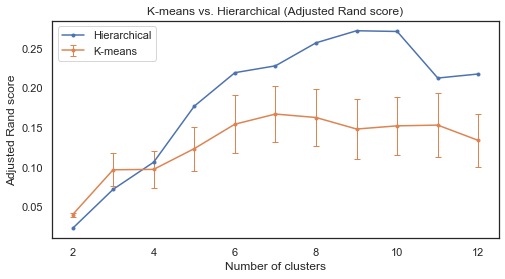

In [51]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(2, 13), rand_score_ac, marker='.')
plt.errorbar(np.arange(2, 13), rand_score_mean, rand_score_std, elinewidth=1, capsize=3, marker='.')
plt.xlabel('Number of clusters')
plt.ylabel('Adjusted Rand score')
plt.title('K-means vs. Hierarchical (Adjusted Rand score)')
plt.legend(('Hierarchical', 'K-means'));

**We can see from the plot that the hierarchical model is always better than the other one when the number of clusters is greater than 3.** The former one reaches the highest score when n equals to 9, while the latter one reaches the highest score when n equals to 7.

### 4.4.2 Silhouette score

Let's plot silhouette scores vs. number of clusters for two unsupervised learning models.

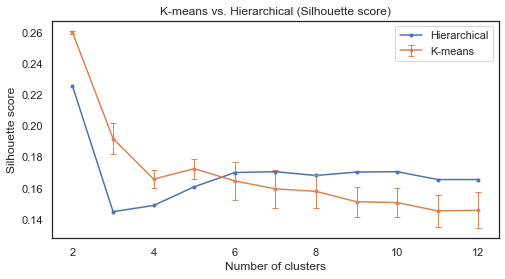

In [52]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(2, 13), silhouette_score_ac, marker='.')
plt.errorbar(np.arange(2, 13), silhouette_score_mean, silhouette_score_std, elinewidth=1, capsize=3, marker='.')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('K-means vs. Hierarchical (Silhouette score)')
plt.legend(('Hierarchical', 'K-means'));

**This plot shows similar results to the above one that K-means performs better when number of clusters is small, while Hierarchical clustering is the better choice when number of clusters increases.**

Though the score reaches highest when *n* equals 2 for hierarchical model, we might consider the model with n equal to **7**, which is coincidentally the same as the number of true labels we set before, as a better one because of the trade-off between number of clusters and the score. 

## 4.5 Summary and further analysis

The main evaluation results for both models are shown below:

| Model name | Best adjusted Rand score | "Best" silhouette score* |
| :---- | ----: | ----: |
| K-means | 0.167 (*n* = 7) | **0.172** (*n* = 5) |
| Hierarchical | **0.272** (*n* = 9) | 0.171 (*n* = 7) |

*Notes: as explained before, the "best" score is not always the highest.*

As shown in the table, under silhouette score, the difference of performance for these two models are not obvious; however, under adjusted Rand score, the Hierarchical model performs much better.

Let's take the Hierarchical model with *n* equal to 7 as an example, to see whether our clustering results make sense.

In [53]:
# retrain the model
ac = AgglomerativeClustering(n_clusters=7)
ac.fit(X_clust)

# print the results
for i in range(7):
    print(f'Cluster {i+1}: ')
    for j in range(49):
        if ac.labels_[j] == i:
            print(df_weather_clust_loc.index[j], end=', ')
    print('\n')

Cluster 1: 
Cobar, Moree, Mildura, Nhil, Nuriootpa, Woomera, PearceRAAF, PerthAirport, SalmonGums, AliceSprings, Uluru, 

Cluster 2: 
MountGinini, Ballarat, Sale, MelbourneAirport, Melbourne, Portland, Watsonia, Dartmoor, MountGambier, Hobart, 

Cluster 3: 
NorfolkIsland, Albany, Witchcliffe, Walpole, 

Cluster 4: 
Cairns, Townsville, Darwin, Katherine, 

Cluster 5: 
Albury, BadgerysCreek, Newcastle, Penrith, Richmond, WaggaWagga, Canberra, Tuggeranong, Bendigo, Launceston, 

Cluster 6: 
Brisbane, Adelaide, Perth, 

Cluster 7: 
CoffsHarbour, NorahHead, Sydney, SydneyAirport, Williamtown, Wollongong, GoldCoast, 



Here are some findings:

* This model performs really well in distinguishing the weather in **Victoria** (7 of 10 locations in Cluster 2 are in Victoria State);

* It is also doing well in distinguishing the weather near the capital, Canberra, in **New South Wales** and **Australian Capital Territory** (8 of 10 locations in Cluster 5 are in NSW or ACT, and we said before that these two areas can be treated as the same);

* It clusters the three cities at the Southwest corner of **West Australia** in Cluster 3;

* It performs so-so in distinguishing between **North Territory** and **Queensland** (Cluster 4 consist of 2 from NT and 2 from QLD, though these two areas are close to each other geometrically); 

* However, it seems that it is extremely confused about distinguishing the weather in **South Australia** and **Tasmania**.

In conclusion, our model cannot match perfectly with previously set 7 divisions, but it is a good chance to learn to train clustering models!